In [3]:
import csv
import cv2
import numpy as np
import sys
import os
import sklearn
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout

from keras.layers.convolutional import Convolution2D
from keras.layers.pooling  import MaxPooling2D

from sklearn.model_selection import train_test_split

from keras.models import Model

import matplotlib.image as mpimg

In [4]:
# loads data from .csv file
# skips first line if it contains descriptions
def load_data(data_csv, skip_first_line):
    samples = []
    with open(data_csv) as csvfile:
        reader = csv.reader(csvfile)
        first_line = True
        for line in reader:
            if first_line and skip_first_line:
                first_line = False
                continue

            # default data was recorded on the unix machine
            line[0] = line[0].replace("/", os.sep)
            samples.append(line)

    print("loaded ", len(samples), " samples from ", data_csv)

    return samples


# generator for model.fit()
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:  # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                batch_sample_paths = batch_sample[0].split(os.sep)
                if (len(batch_sample_paths) < 3):
                    name = os.path.join("data", "default", batch_sample_paths[-2], batch_sample_paths[-1])
                else:
                    name = os.path.join("data", batch_sample_paths[-3], batch_sample_paths[-2], batch_sample_paths[-1])

                center_image = mpimg.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


# load the data
data_directory = "data"

samples = []

for child in os.listdir(data_directory):
    subdata_dir = os.path.join(data_directory, child)
    if os.path.isdir(subdata_dir):
        subdata_path = os.path.join(subdata_dir, "driving_log.csv")
        subdata = load_data(subdata_path, child == "default")
        samples.extend(subdata)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

ch, row, col = 3, 160, 320  

model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(row, col, ch),
        output_shape=(row, col, ch)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

# my Nvidia-based architecture
model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))

model.add(Flatten())

model.add(Dense(1024))
model.add(Dropout(0.3))

model.add(Dense(256))
model.add(Dropout(0.3))

model.add(Dense(64))
model.add(Dropout(0.3))

model.add(Dense(32))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, 
                    samples_per_epoch=len(train_samples),  
                    validation_data=validation_generator, 
                    nb_val_samples=len(validation_samples), 
                    nb_epoch=4)

model.save('model.h5')

loaded  6348  samples from  data\backward\driving_log.csv
loaded  8036  samples from  data\default\driving_log.csv
loaded  4723  samples from  data\forward\driving_log.csv
loaded  1097  samples from  data\stability\driving_log.csv
Epoch 1/4
16163/16163 [==============================] - 33s - loss: 0.0401 - val_loss: 0.0300
Epoch 2/4
16163/16163 [==============================] - 29s - loss: 0.0262 - val_loss: 0.0347
Epoch 3/4
16163/16163 [==============================] - 30s - loss: 0.0235 - val_loss: 0.0261
Epoch 4/4
16163/16163 [==============================] - 30s - loss: 0.0214 - val_loss: 0.0220


dict_keys(['val_loss', 'loss'])


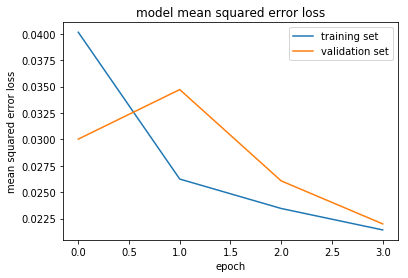

In [5]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()